## Data

### Shapefiles

[data.humdata.org](data.humdata.org)

### GNS (I dont think I use it here)

To merge with the shapefiles [https://geonames.nga.mil/geonames/GNSData/](https://geonames.nga.mil/geonames/GNSData/)

### Protests
To get the data I used tehh GDELT project and queried from BigQuerry the following SQL

Instructions for the future!

```sql
SELECT
  ActionGeo_CountryCode, ActionGeo_Lat, ActionGeo_Long, ActionGeo_FeatureID, SQLDATE, Year
FROM
  `gdelt-bq.full.events`
WHERE 
  ActionGeo_CountryCode IN("CI","AR","BH","BR","CO","CS","CU","DR",
  "ES","EC","GT","GY") -- Subset for Chile
  AND EventRootCode = '14' -- Subset Protest
```

```sql
SELECT
  ActionGeo_CountryCode, ActionGeo_Lat, ActionGeo_Long, ActionGeo_FeatureID, SQLDATE, Year
FROM
  `gdelt-bq.full.events`
WHERE 
  ActionGeo_CountryCode IN("HO","JM","NU","PE","PA","RQ","UY","VE","BL") -- Subset for Chile
  AND EventRootCode = '14' -- Subset Protest
```

In [1]:
#dealing with missings
!=ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x != y;
==ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x == y;
>=ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x >= y;
<=ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x <= y;
<ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x < y;
>ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x > y;


In [2]:
using CSV, DataFrames, GeoDataFrames, Shapefile, GeoJSON, GeoMakie, CairoMakie, Dates, Rasters

In [ ]:
# Combine the two datasets downloaded from GDELT

In [8]:
protests = DataFrame(CSV.File("../data/GDELT/chile_protest_events.csv"))
protests.month = parse.(Int, [s[5:6] for s in string.(protests.SQLDATE)])
protests.day = parse.(Int, [s[7:8] for s in string.(protests.SQLDATE)])
protests.date = Date.(protests.Year, protests.month, protests.day);

# Only select those with a very granular geo reference
protests = protests[protests.ActionGeo_FeatureID .!=ₘ "CI",:]

Row,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,Actor1Type1Code,Actor2Type1Code,SQLDATE,Year,month,day,date
,Float64,Float64,String15?,String3?,String3?,Int64,Int64,Int64,Int64,Date
1,-30.0,-71.0,0,missing,JUD,19970731,1997,7,31,1997-07-31
2,-30.0,-71.0,0,OPP,COP,20090309,2009,3,9,2009-03-09
3,-30.0,-71.0,0,GOV,GOV,20110126,2011,1,26,2011-01-26
4,-33.45,-70.6667,-901202,COP,EDU,20120824,2012,8,24,2012-08-24
5,-33.45,-70.6667,-901202,GOV,GOV,19841107,1984,11,7,1984-11-07
6,-22.4667,-68.9333,-874643,missing,missing,20091021,2009,10,21,2009-10-21
7,-26.55,-69.7,-886187,LAB,missing,20130814,2013,8,14,2013-08-14
8,-36.7167,-73.1167,-902298,GOV,missing,20100303,2010,3,3,2010-03-03
9,-29.9533,-71.3436,-878459,missing,missing,20120217,2012,2,17,2012-02-17


In [9]:
protests.coords = collect(zip(protests.ActionGeo_Long,protests.ActionGeo_Lat))

12689-element Vector{Tuple{Float64, Float64}}:
 (-71.0, -30.0)
 (-71.0, -30.0)
 (-71.0, -30.0)
 (-70.6667, -33.45)
 (-70.6667, -33.45)
 (-68.9333, -22.4667)
 (-69.7, -26.55)
 (-73.1167, -36.7167)
 (-71.3436, -29.9533)
 (-70.6667, -33.45)
 ⋮
 (-70.6667, -33.45)
 (-70.6667, -33.45)
 (-70.6667, -33.45)
 (-70.6667, -33.45)
 (-70.6667, -33.45)
 (-70.6667, -33.45)
 (-70.6667, -33.45)
 (-70.6667, -33.45)
 (-70.6667, -33.45)

In [10]:
protest_agg = DataFrames.combine(groupby(protests, [:ActionGeo_Lat, :ActionGeo_Long, :Year, :month]), nrow => :n_count)
protest_rasters = DataFrames.combine(groupby(protests, [:coords, :Year, :month]), nrow => :n_count)
sort!(protest_agg, [:Year, :month])

Row,ActionGeo_Lat,ActionGeo_Long,Year,month,n_count
,Float64,Float64,Int64,Int64,Int64
1,-33.45,-70.6667,1920,1,21
2,-33.05,-71.65,1920,1,1
3,-30.0,-71.0,1979,4,1
4,-30.0,-71.0,1979,5,5
5,-33.45,-70.6667,1979,6,1
6,-33.45,-70.6667,1979,8,1
7,-33.45,-70.6667,1979,9,4
8,-33.0081,-71.5197,1979,9,1
9,-30.0,-71.0,1979,9,1


In [11]:
# Need to transform to a GeoDataFrame
# Not sure why x is Long and y is Lat here
df = DataFrame(geometry=createpoint.(protest_rasters.coords))

Row,geometry
,IGeometr…
1,Geometry: wkbPoint
2,Geometry: wkbPoint
3,Geometry: wkbPoint
4,Geometry: wkbPoint
5,Geometry: wkbPoint
6,Geometry: wkbPoint
7,Geometry: wkbPoint
8,Geometry: wkbPoint
9,Geometry: wkbPoint


In [75]:
# Can I get some of these data to raster form?
protest_raster = rasterize(count, df.geometry; res = .6)

71×63 Raster{Int64,2} count with dimensions: 
  X Projected{Float64} -109.45:0.594130985915493:-67.8608309859155 ForwardOrdered Regular Intervals{Start},
  Y Projected{Float64} -55.9833:0.5997349206349206:-18.799734920634922 ForwardOrdered Regular Intervals{Start}
extent: Extent(X = (-109.45, -67.2667), Y = (-55.9833, -18.200000000000003))missingval: 0parent:
            -55.9833  -55.3836  -54.7838  …  -19.9992  -19.3995  -18.7997
 -109.45      0         0         0            0         0         0
 -108.856     0         0         0            0         0         0
 -108.262     0         0         0            0         0         0
 -107.668     0         0         0            0         0         0
 -107.073     0         0         0       …    0         0         0
    ⋮                                     ⋱              ⋮       
  -70.8315    0         0         0            0         0         0
  -70.2374    0         0         0           16         2         1
  -69.6432    0

In [13]:
country = GeoDataFrames.read("../data/geometries/CHL/shapefile/chl_admbnda_adm0_bcn_20211008.shp")

Row,geometry,Shape_Leng,Shape_Area,ADM0_ES,ADM0_PCODE,ADM0_REF,ADM0ALT1ES,ADM0ALT2ES,date,validOn,validTo
,IGeometr…,Float64,Float64,String,String,Missing,Missing,Missing,DateTime,DateTime,Nothing
1,Geometry: wkbMultiPolygon,1106.83,78.9579,Chile,CL,missing,missing,missing,2021-08-03T00:00:00,2021-10-08T00:00:00,


In [15]:
# Chilean Polygons
# chile_pol = GeoDataFrames.read("../data/geometries/CHL/shapefile/chl_admbnda_adm3_bcn_20211008.shp")
# RM_sel = chile_pol.ADM1_ES .== "Región Metropolitana de Santiago"
# chile_pol.intensity = rand(size(chile_pol,1));
# chile_pol = chile_pol[RM_sel,:]

I need to change to GeoJSON for makie to work

In [18]:
# GeoDataFrames.write("../data/geometries/CHL/RM.geojson", chile_pol[:,["geometry"]]; crs=GeoFormatTypes.EPSG(3857))
GeoDataFrames.write("../data/geometries/CHL/country.geojson", country[:,["geometry"]]; crs=GeoFormatTypes.EPSG(3857))

"../data/geometries/CHL/country.geojson"

In [19]:
chile_poly = GeoJSON.read("../data/geometries/CHL/country.geojson")
# RM_polygons = GeoJSON.read("../data/geometries/CHL/RM.geojson")

FeatureCollection with 1 Features

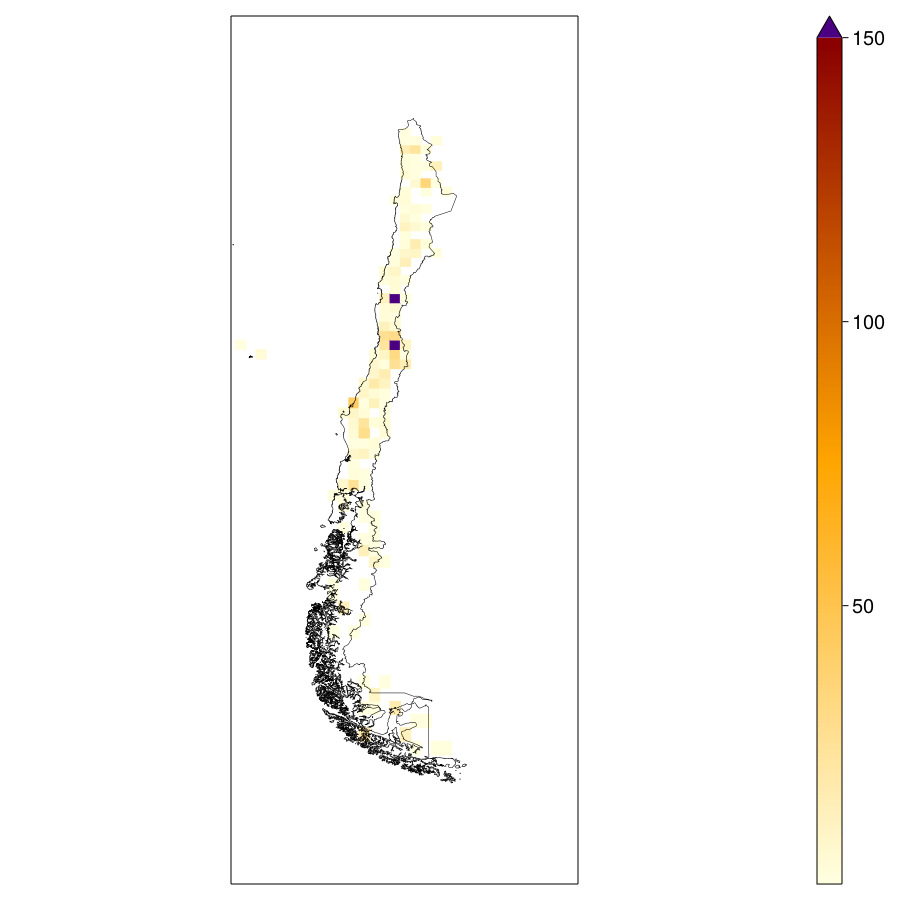

In [76]:
fig = Figure(
    resolution = (900, 900),
    fontsize = 20
)
ga = GeoAxis(
    fig[1, 1]; # any cell of the figure's layout
    dest = "+proj=merc", lonlims=(-80, -60), latlims = (-60, -10),
    coastlines = false # plot coastlines from Natural Earth, as a references
)

phet = heatmap!(ga, protest_raster;
                 colormap = :heat, colorrange = (1,150), highclip = :indigo)
poly!(ga, chile_poly;
                color = :transparent, alpha = 0.1, strokewidth = .5, strokecolor = :black)
# sa = scatter!(ga, protest_agg.ActionGeo_Long, protest_agg.ActionGeo_Lat, marker = :circle, markersize = 20, color = :black,
#               label = "events")
# Legend(fig[1,2], ga)
Colorbar(fig[:, 2], phet; size = 25)
resize_to_layout!(fig)
hidedecorations!(ga)
fig